#Example-1

In [ ]:
pwd

'/content'

In [ ]:
mkdir .kaggle

In [ ]:
#importing json file. PLS USE YOUR OWN PASSWORD
import json
token = {"username":"","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
ls -la

total 20
drwxr-xr-x 1 root root 4096 Sep 19 13:02 ./
drwxr-xr-x 1 root root 4096 Sep 19 13:01 ../
drwxr-xr-x 4 root root 4096 Sep 16 13:39 .config/
drwxr-xr-x 2 root root 4096 Sep 19 13:02 .kaggle/
drwxr-xr-x 1 root root 4096 Sep 16 13:40 sample_data/


In [ ]:
cd /root

/root


In [ ]:
ls -la

total 64
drwx------ 1 root root 4096 Sep 19 13:01 ./
drwxr-xr-x 1 root root 4096 Sep 19 13:01 ../
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc*
drwxr-xr-x 1 root root 4096 Sep 16 14:09 .cache/
drwxr-xr-x 1 root root 4096 Sep 16 14:07 .config/
drwxr-xr-x 3 root root 4096 Sep 16 13:40 .gsutil/
drwxr-xr-x 1 root root 4096 Sep 16 14:07 .ipython/
drwx------ 2 root root 4096 Sep 16 14:07 .jupyter/
drwxr-xr-x 2 root root 4096 Sep 19 13:01 .keras/
drwx------ 1 root root 4096 Sep 16 14:07 .local/
drwxr-xr-x 4 root root 4096 Sep 16 14:07 .npm/
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf*


In [ ]:
!mkdir .kaggle

In [ ]:
cd /root/.kaggle

/root/.kaggle


In [ ]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
ls -la

total 16
drwxr-xr-x 2 root root 4096 Sep 19 13:02 ./
drwx------ 1 root root 4096 Sep 19 13:02 ../
-rw-r--r-- 1 root root   70 Sep 19 13:02 kaggle.json


In [ ]:
cd /content

/content


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013 -p /content/drivers

 86% 52.0M/60.3M [00:00<00:00, 84.5MB/s]
100% 60.3M/60.3M [00:00<00:00, 123MB/s] 


In [ ]:
cd drivers

/content/drivers


In [ ]:
!unzip '/content/drivers/fer2013.zip'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drivers/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drivers/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drivers/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

In [ ]:
# Model Summary
for layer in base_model.layers:
    layer.trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [ ]:
print(base_model.layers[18].trainable)

False


In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 15,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/15
359/359 [==============================] - 74s 116ms/step - loss: 1.7998 - accuracy: 0.8562 - precision: 0.4155 - recall: 0.0170 - auc: 0.6756 - f1_score: 0.0303 - val_loss: 1.7459 - val_accuracy: 0.8585 - val_precision: 0.6626 - val_recall: 0.0188 - val_auc: 0.6946 - val_f1_score: 0.0359
Epoch 2/15
359/359 [==============================] - 40s 112ms/step - loss: 1.7458 - accuracy: 0.8573 - precision: 0.5124 - recall: 0.0224 - auc: 0.6959 - f1_score: 0.0422 - val_loss: 1.7136 - val_accuracy: 0.8584 - val_precision: 0.5831 - val_recall: 0.0300 - val_auc: 0.7125 - val_f1_score: 0.0561
Epoch 3/15
359/359 [==============================] - 40s 110ms/step - loss: 1.7392 - accuracy: 0.8572 - precision: 0.5054 - recall: 0.0246 - auc: 0.7003 - f1_score: 0.0461 - val_loss: 1.6889 - val_accuracy: 0.8583 - val_precision: 0.6438 - val_recall: 0.0179 - val_auc: 0.7309 - val_f1_score: 0.0345
Epoch 4/15
359/359 [==============================] - 39s 109ms/step - loss: 1.7343 - accuracy: 0

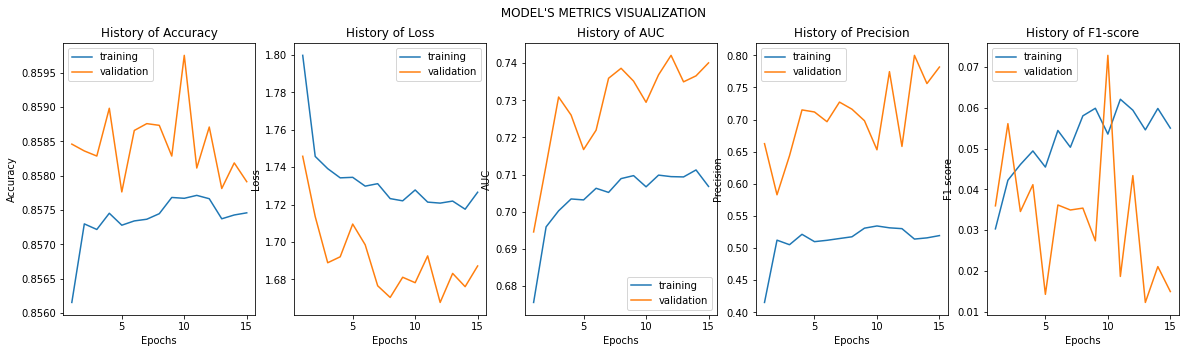

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

#Example2

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img

import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.applications import VGG16
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [ ]:
from tensorflow.keras import optimizers
IMAGE_SIZE = 48
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

num_epochs = 60
batch_size = 64

pre_trained_model = VGG16(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

for layer in pre_trained_model.layers[:20]:
    layer.trainable = False

for layer in pre_trained_model.layers[20:]:           # I'll retrain the network from 20th layer
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

x = layers.Dense(7, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),    # I used different learning rates. Turned out, 1e-4 is performing the best among them.
              metrics=METRICS)

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=5,
                                   rescale=1./255,
                                   validation_split=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

In [ ]:
train_dataset = train_datagen.flow_from_directory(directory='/content/drivers/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='training',
                                                  batch_size=64)

valid_dataset = valid_datagen.flow_from_directory(directory='/content/drivers/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  batch_size=64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_vgg16.h5')

es = EarlyStopping(verbose=1, patience=10)

In [ ]:
history = model.fit_generator(train_dataset,
                              epochs=50,
                              callbacks=[lrd,mcp,es],
                              validation_data=valid_dataset,
                              validation_steps=5741//batch_size,
                              steps_per_epoch=22968//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 74s 117ms/step - loss: 1.8340 - accuracy: 0.8557 - precision: 0.4027 - recall: 0.0208 - auc: 0.6621 - val_loss: 1.6870 - val_accuracy: 0.8576 - val_precision: 0.6393 - val_recall: 0.0068 - val_auc: 0.7286
Epoch 2/50
358/358 [==============================] - 41s 114ms/step - loss: 1.7148 - accuracy: 0.8580 - precision: 0.5663 - recall: 0.0259 - auc: 0.7126 - val_loss: 1.6630 - val_accuracy: 0.8588 - val_precision: 0.6179 - val_recall: 0.0304 - val_auc: 0.7364
Epoch 3/50
358/358 [==============================] - 41s 114ms/step - loss: 1.6819 - accuracy: 0.8587 - precision: 0.5942 - recall: 0.0337 - auc: 0.7276 - val_loss: 1.6470 - val_accuracy: 0.8596 - val_precision: 0.6300 - val_recall: 0.0413 - val_auc: 0.7430
Epoch 4/50
358/358 [==============================] - 41s 115ms/step - loss: 1.6627 - accuracy: 0.8595 - precision: 0.6166 - recall: 0.0432 - auc: 0.7372 - val_loss: 1.6369 - val_accuracy: 0.8600 - val_precision: 0.6505 - v

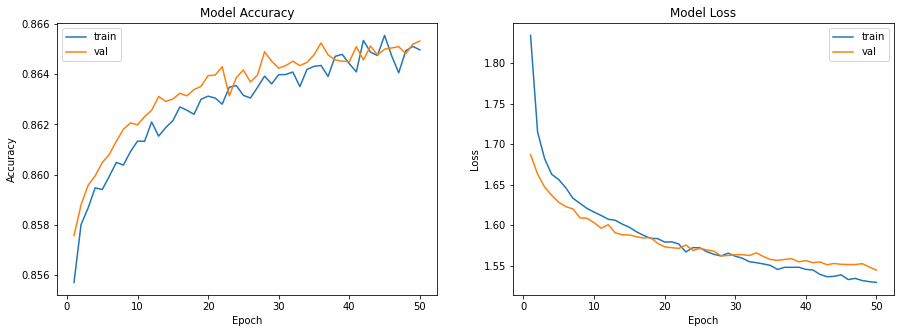

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

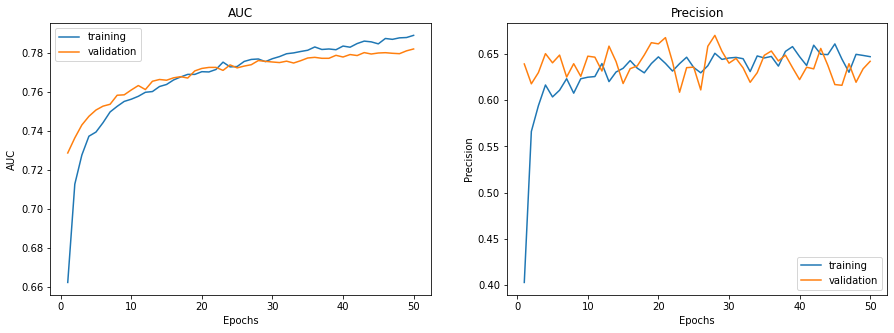

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(range(1, len(auc) + 1), auc)
ax1.plot(range(1, len(val_auc) + 1), val_auc)
ax1.set_title('AUC')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC')
ax1.legend(['training', 'validation'])

ax2.plot(range(1, len(precision) + 1), precision)
ax2.plot(range(1, len(val_precision) + 1), val_precision)
ax2.set_title('Precision')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend(['training', 'validation'])

In [ ]:
# Let's check the class indices to use it later

expression_dict = list(train_dataset.class_indices.keys())
expression_dict

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

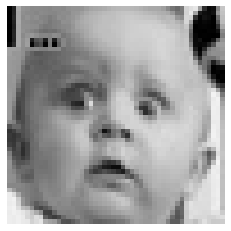

surprise
[[0.06934544 0.00327617 0.11425254 0.05501379 0.07983987 0.01822081
  0.6600514 ]]


In [ ]:
from keras.preprocessing import image

def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(48,48))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


# loaded_model = load_model("model_vgg16.h5")

img_path = '/content/drivers/test/surprise/PrivateTest_10089743.jpg'

new_image = load_image(img_path)

pred = model.predict(new_image)

predictions = list(pred[0])
expression_output = expression_dict[(predictions.index(max(predictions)))]

print(expression_output)
print(pred)